In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import convolve1d
from torch.utils import data
import os

In [2]:
# utils.py: Define some utility functions (not the focus of this course).
import os
import shutil
import torch
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def get_lds_kernel_window(kernel, ks, sigma):
    assert kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (ks - 1) // 2
    if kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(base_kernel, sigma=sigma) / max(gaussian_filter1d(base_kernel, sigma=sigma))
    elif kernel == 'triang':
        kernel_window = triang(ks)
    else:
        laplace = lambda x: np.exp(-abs(x) / sigma) / (2. * sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window


In [3]:
class DNA_loader(data.Dataset):
    def __init__(self, labels,dna, split='train', reweight='none',
                 lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.split = split
        self.labels= labels
        
        self.dna = self.seq2onehot(dna)
        
        self.weights = self.weights = self._prepare_weights(reweight=reweight, lds=lds, lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)
        # # 对weights进行标准化
        # if self.weights is not None:
        #     self.weights = (self.weights - np.mean(self.weights)) / np.std(self.weights)
    def __len__(self):
        return self.labels.shape[0]
    


    def __getitem__(self, index):
        index = index % self.labels.shape[0]
        feature = np.transpose(self.dna[index], (2, 0, 1))
        label = self.labels[index]
        weight = np.asarray([self.weights[index]]).astype('float32') if self.weights is not None else np.asarray([np.float32(1.)])
        return feature, weight, label
    

    
    def seq2onehot(self,seq):     #convert the cRBS sequences to one-hot encoding
        module = np.array([[[1,0,0,0]],
                           [[0,1,0,0]],
                           [[0,0,1,0]],
                           [[0,0,0,1]]])
        i = 0
        cRBS_onehot = []
        for i in seq:
            tmp = []
            for item in i:
                if item == 't' or item == 'T':
                    tmp.append(module[0])
                elif item == 'c' or item == 'C':
                    tmp.append(module[1])
                elif item == 'g' or item == 'G':
                    tmp.append(module[2])
                elif item == 'a' or item == 'A':
                    tmp.append(module[3])
                else:
                    tmp.append([[0,0,0,0]])
            cRBS_onehot.append(tmp)
        cRBS_onehot=np.array(cRBS_onehot).astype('float32')
        return cRBS_onehot

    def _prepare_weights(self, reweight, max_target=101, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        assert reweight in {'none', 'inverse', 'sqrt_inv'}
        assert reweight != 'none' if lds else True, \
            "Set reweight to \'sqrt_inv\' (default) or \'inverse\' when using LDS"

        value_dict = {x: 0 for x in range(max_target)}
        labels = self.labels.tolist()
        # mbr   
        for label in labels:
            value_dict[min(max_target - 1, int(label))] += 1
        if reweight == 'sqrt_inv':
            value_dict = {k: np.sqrt(v) for k, v in value_dict.items()}
        elif reweight == 'inverse':
            value_dict = {k: np.clip(v, 5, 1000) for k, v in value_dict.items()}  # clip weights for inverse re-weight
        num_per_label = [value_dict[min(max_target - 1, int(label))] for label in labels]
        if not len(num_per_label) or reweight == 'none':
            return None
        print(f"Using re-weighting: [{reweight.upper()}]")
        if lds:
            lds_kernel_window = get_lds_kernel_window(lds_kernel, lds_ks, lds_sigma)
            print(f'Using LDS: [{lds_kernel.upper()}] ({lds_ks}/{lds_sigma})')
            smoothed_value = convolve1d(
                np.asarray([v for _, v in value_dict.items()]), weights=lds_kernel_window, mode='constant')
            num_per_label = [smoothed_value[min(max_target - 1, int(label))] for label in labels]

        weights = [np.float32(1 / x) for x in num_per_label]
        scaling = len(weights) / np.sum(weights)
        weights = [scaling * x for x in weights]
        return weights

In [4]:
x_train=pd.read_excel('data/promoter_w_20799.xlsx',header=None).to_numpy().reshape(-1)
y_train=pd.read_excel('data/mapped_labels.xlsx',header=None).to_numpy().reshape(-1)

In [5]:
train_data, temp_data, train_labels, temp_labels = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

train_dataset = DNA_loader(labels=train_labels, dna=train_data,split='train',
                        reweight='inverse', lds=True, lds_kernel='gaussian', lds_ks=20, lds_sigma=10)
val_dataset = DNA_loader(labels=val_labels, dna=val_data,split='train',
                        reweight='inverse', lds=True, lds_kernel='gaussian', lds_ks=5, lds_sigma=2)
test_dataset = DNA_loader(labels=test_labels, dna=test_data,split='train',
                        reweight='inverse', lds=True, lds_kernel='gaussian', lds_ks=5, lds_sigma=2)


Using re-weighting: [INVERSE]
Using LDS: [GAUSSIAN] (20/10)
Using re-weighting: [INVERSE]
Using LDS: [GAUSSIAN] (5/2)
Using re-weighting: [INVERSE]
Using LDS: [GAUSSIAN] (5/2)


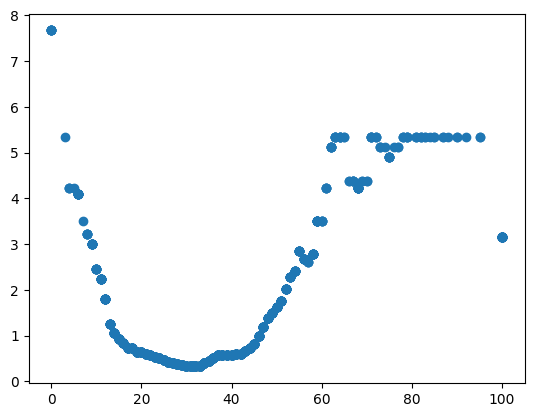

In [6]:
# 设计一个函数，提取train_dataset中的权重
def get_weight(train_dataset):
    weight=[]
    for i in range(len(train_dataset)):
        weight.append(train_dataset[i][1][0])
    return weight
weights = get_weight(test_dataset)
# 提取train_datasetd的labels,定义为get_labels函数
def get_labels(train_dataset):
    labels=[]
    for i in range(len(train_dataset)):
        labels.append(train_dataset[i][2])
    return labels
labels = get_labels(test_dataset)
# 读取features from train_dataset
def get_features(train_dataset):
    features=[]
    for i in range(len(train_dataset)):
        features.append(train_dataset[i][0])
    features=np.array(features)
    return features
# 将labels和weights合并在一起绘制其中的关系图
import matplotlib.pyplot as plt
plt.scatter(labels,weights)
plt.show()

# # 可视化weights的分布
# import matplotlib.pyplot as plt
# plt.hist(weights, bins=100)
# plt.show()


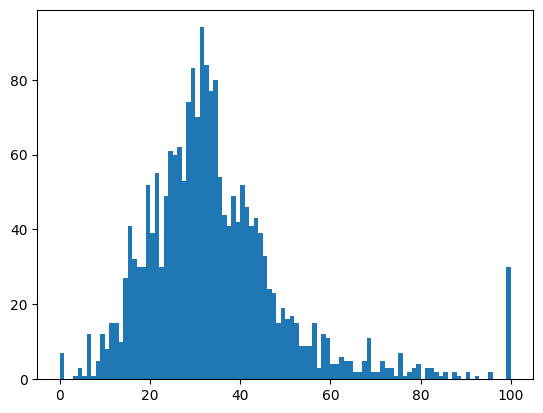

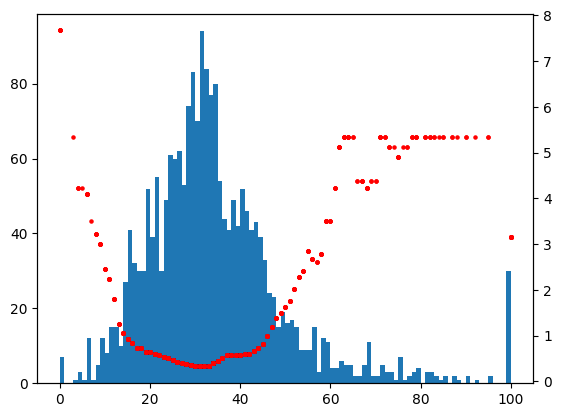

In [7]:
# labes的分布图
import matplotlib.pyplot as plt
plt.hist(labels, bins=100)
plt.show()
# 将上面的scatter图和hist图合并在一起，用不同的颜色标注
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.hist(labels, bins=100)
ax2 = ax1.twinx()
ax2.scatter(labels,weights,color='red',s=5)
plt.show()
